In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, recall_score, accuracy_score
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import seaborn as sns
from scipy import ndimage, spatial, special
import scipy.optimize as optimize
import os
from radiomics import featureextractor
import radiomics
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import numpy as np
import pandas as pd
import math
import datatable as dt
from sklearn.metrics import roc_curve, roc_auc_score
from skimage import io, transform
import seaborn as sns
import pickle
from torch.utils.data import DataLoader, Dataset
import glob
from PIL import Image
%matplotlib widget
import matplotlib.pyplot as plt

In [54]:
try:
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs available:", num_gpus)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
except Exception as e:
    print("Error while checking GPUs:", e)

Number of GPUs available: 3
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000


In [55]:
print(torch.cuda.is_available())
device = torch.device("cuda:1")

True


In [56]:
# Define your CNN model
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*12*12, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x= self.dropout_conv(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [57]:
class ToTensor(object):

    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        if shape=='Round':
            shape=0
        elif shape=='Irregular':
            shape=1
        elif shape=='Ambiguous':
            shape=2
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'shape': torch.from_numpy(np.asarray(shape))}

In [58]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        norm = transforms.Normalize(mean=self.mean, std=self.std)
        return {'image': norm(image.float()),
                'shape': shape}

In [59]:
# Load the models
model_paths = ['model_shape_0.pt', 'model_shape_1.pt', 'model_shape_2.pt', 'model_shape_3.pt', 'model_shape_4.pt']
models = []

for path in model_paths:
    model = simpleNet()
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    models.append(model)

In [60]:
class AxialCutsDataset(Dataset):

    def __init__(self, data_shape, transform=None, for_trainning=False, mean=False, std=False, downsample=False):
        self.data = data_shape
        self.transform=transform
        self.for_trainning = for_trainning
        self.mean= mean
        self.std = std
        self.downsample = downsample

        if self.downsample:
            df_majority = self.data[self.data.iloc[:, 1]=='Irregular']
            df_majority_downsampled = resample(df_majority, replace=False, n_samples=1200, random_state=125)
            self.data = pd.concat((self.data[self.data['Shape'] != 'Irregular'], df_majority_downsampled))

    def __len__(self):
        return len(self.data.iloc[:, 0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]
        image = io.imread(img_name)
        shape = self.data.iloc[idx, 1]
        sample = {'image': image, 'shape': shape}

        if self.transform:
            sample = self.transform(sample)

        return sample
        


mean = 87.42158495776914
std = 29.82248099334633

In [61]:
mean = 87.42158495776914
std = 29.82248099334633

In [62]:
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)


axialcuts_dataset_eval = AxialCutsDataset(data_shape=data, downsample=False)
data_without_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']!='Ambiguous']
data_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']=='Ambiguous']

In [63]:
images_path_tr = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/'
data_tr = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_tr}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_tr}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path_tr}*/*png')]
        ),
    ),
    axis=1,
)
data_tr.columns = ['Path', 'ID', 'Shape']
data_tr.set_index('ID', inplace=True)
axialcuts_dataset_tr = AxialCutsDataset(data_shape=data_tr, downsample=False)
data_amb_tr = axialcuts_dataset_tr.data[axialcuts_dataset_tr.data['Shape']=='Ambiguous']

In [64]:
data_transforms = transforms.Compose([
    ToTensor(),
    Normalize(mean=mean, std=std)
])

In [65]:
data_without_amb = AxialCutsDataset(data_shape=data_without_amb, downsample=False, transform=data_transforms)
data_amb = AxialCutsDataset(data_shape=data_amb, downsample=False, transform=data_transforms)
data_amb_tr = AxialCutsDataset(data_shape=data_amb_tr, downsample=False, transform=data_transforms)

In [66]:
eval_data = DataLoader(data_without_amb, num_workers=12)
eval_data_amb = DataLoader(data_amb, num_workers=12)
tr_data_amb = DataLoader(data_amb_tr, num_workers=12)

In [67]:
# Define functions for evaluation metrics
def accuracy(outputs, labels):
    preds = outputs > 0.5 
    return accuracy_score(labels, preds)

def f1(outputs, labels):
    preds = outputs > 0.5
    return f1_score(labels, preds, average='binary')

def calculate_sensitivity(outputs, labels):
    preds = outputs > 0.5
    return recall_score(labels, preds, average='binary')

def roc_auc(outputs, labels):
    probs = outputs
    return roc_auc_score(labels, probs)

def compute_confusion_matrix(outputs, labels):
    preds = outputs > 0.5
    return confusion_matrix(labels, preds)

def calculate_specificity(cm):
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    return TN / (TN + FP)

In [68]:
def display_confusion_matrix(cm):
    # Define class names
    class_names = ['Round', 'Irregular']
    
    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 20})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [69]:
def calculate_val_metrics(all_preds, all_labels):

    # Concatenate predictions and labels
    # all_preds = torch.from_numpy(np.concatenate(all_preds, axis=0))
    # all_labels = torch.from_numpy(np.concatenate(all_labels, axis=0))

    # Compute evaluation metrics
    acc = accuracy(all_preds, all_labels)
    f1_result = f1(all_preds, all_labels)
    roc_auc_result = roc_auc(all_preds, all_labels)
    cm = compute_confusion_matrix(all_preds, all_labels)
    display_confusion_matrix(cm)
    sensitivity_value = calculate_sensitivity(all_preds, all_labels)
    specificity_value = calculate_specificity(cm)

    print('Accuracy: {:.6f} \tF1 Score: {:.6f} \tROC AUC: {:.6f} \tSpecificity: {:.6f} \tSensitivity: {:.6f}'.format(
        acc, f1_result, roc_auc_result, specificity_value, sensitivity_value))

In [70]:
# Function to make predictions
def predict(models, image):
    image = image.to(device)
    predictions = [model(image).cpu().detach().numpy() for model in models]
    return predictions

In [71]:
def plot_calibration_curve(y_true, y_prob):
    # Calculate the calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    
    return prob_true, prob_pred

In [72]:
# Store results
all_results = []
mean_pred = []
true_labels = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data:
        images = batch['image']
        labels = batch['shape']

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred.append(np.mean(pred_probs))
        true_labels.append(labels.item())
        all_results.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [73]:
models_pred = [[all_results[k]['predicted_probabilities'][i].ravel() for k in range(len(all_results))] for i in range(5)]

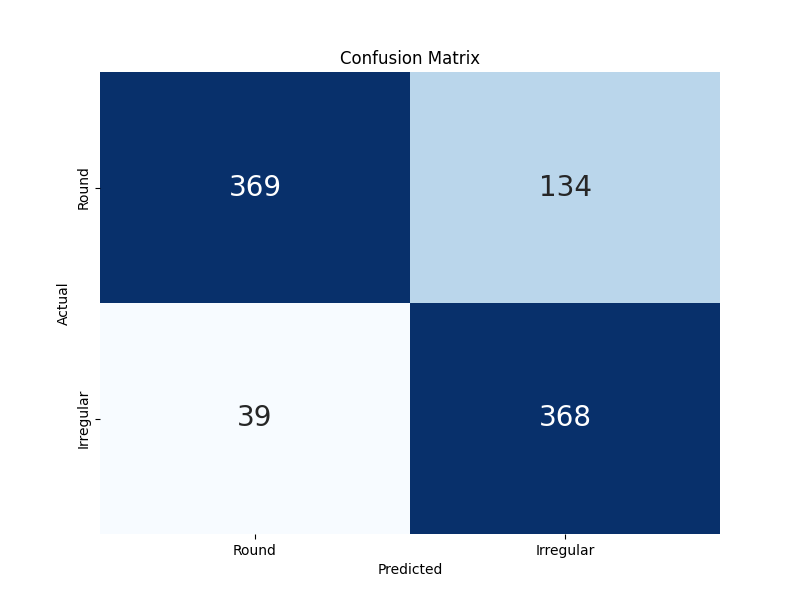

Accuracy: 0.809890 	F1 Score: 0.809681 	ROC AUC: 0.861807 	Specificity: 0.733598 	Sensitivity: 0.904177


In [74]:
calculate_val_metrics(np.array(mean_pred), np.array(true_labels))

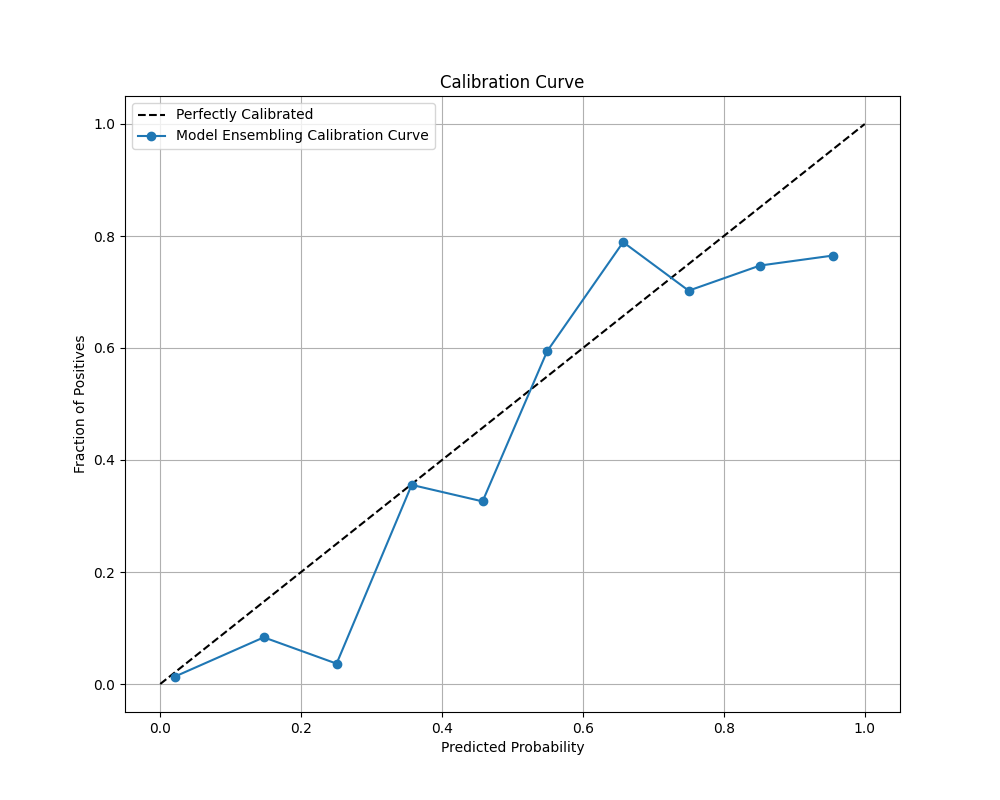

In [75]:
plt.figure(figsize=(10, 8))

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
i = 0
# for res in models_pred:
#     prob_true, prob_pred = plot_calibration_curve(np.array(true_labels), np.array(res).ravel())
#     plt.plot(prob_pred, prob_true, marker='o', label=f'Model_{i} Calibration Curve', alpha = 0.1)
#     i=i+1
prob_true, prob_pred = plot_calibration_curve(np.array(true_labels), np.array(mean_pred))
plt.plot(prob_pred, prob_true, marker='o', label=f'Model Ensembling Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()

In [76]:
good_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class']]
bad_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class']]
good_prob = [0.5-abs((good_results[k]['mean']-0.5)) for k in range(len(good_results))]
bad_prob = [0.5-abs((bad_results[k]['mean']-0.5)) for k in range(len(bad_results))]

failures = np.ones(len(bad_prob))
success = np.zeros(len(good_prob))

In [77]:
good_stds = [good_results[k]['std'] for k in range(len(good_results))]
bad_stds = [bad_results[k]['std'] for k in range(len(bad_results))]

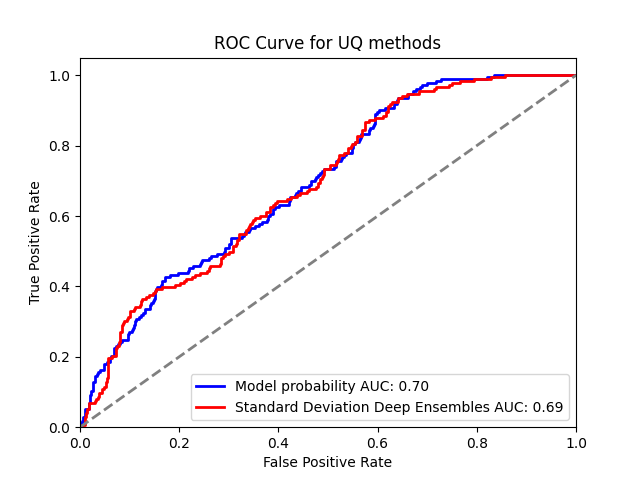

AUC: 0.70
AUC: 0.69


In [78]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(np.concatenate((failures, success)), np.concatenate((bad_prob, good_prob)))
fpr_stds, tpr_stds, thresholds_stds = roc_curve(np.concatenate((failures, success)), np.concatenate((bad_stds, good_stds)))

# Calculate and print AUC
auc_score = roc_auc_score(np.concatenate((failures, success)), np.concatenate((bad_prob, good_prob)))
auc_score_stds = roc_auc_score(np.concatenate((failures, success)), np.concatenate((bad_stds, good_stds)))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Model probability AUC: {auc_score:.2f}')
plt.plot(fpr_stds, tpr_stds, color='red', lw=2, label=f'Standard Deviation Deep Ensembles AUC: {auc_score_stds:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for UQ methods')
plt.legend(loc="lower right")
plt.show()


print(f'AUC: {auc_score:.2f}')
print(f'AUC: {auc_score_stds:.2f}')

/tmp/ipykernel_912677/801943834.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Prob', data=df, inner=None, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 13.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


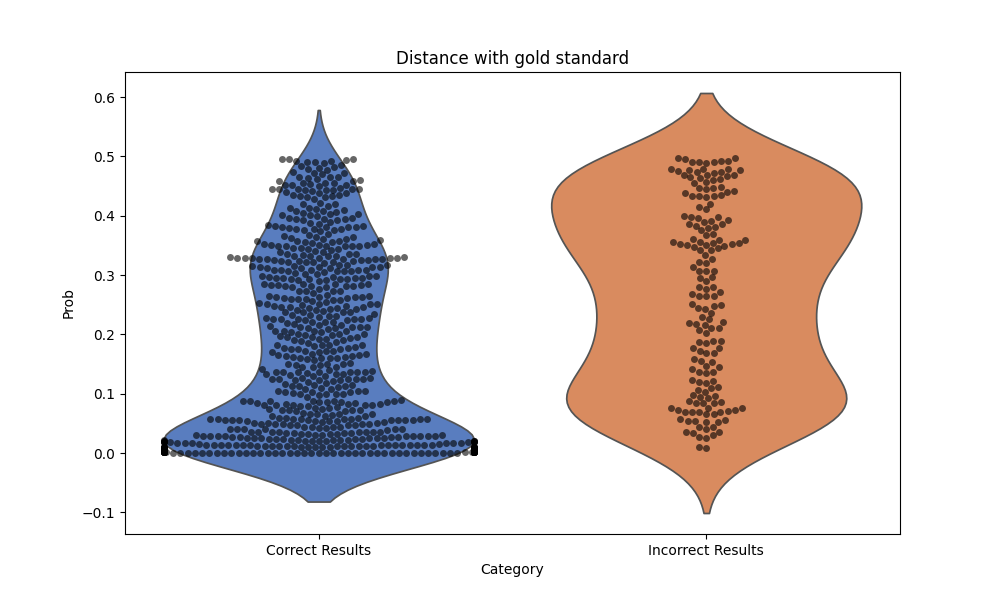

In [79]:
# Prepare the data in a long-form DataFrame
df = pd.DataFrame({
    'Prob': good_prob + bad_prob,# + amb_stds + amb_tr_stds,
    'Category': ['Correct Results'] * len(good_prob) + ['Incorrect Results'] * len(bad_prob)# + ['Ambiguous Cuts Eval DB'] * len(amb_stds) + ['Train DB'] * len(amb_tr_stds)
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x='Category', y='Prob', data=df, inner=None, palette='muted')

# Add the scatter points
sns.swarmplot(x='Category', y='Prob', data=df, color='k', alpha=0.6)

# Show the plot
plt.title('Distance with gold standard')
plt.show()

/tmp/ipykernel_912677/609409600.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Prob', data=df, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


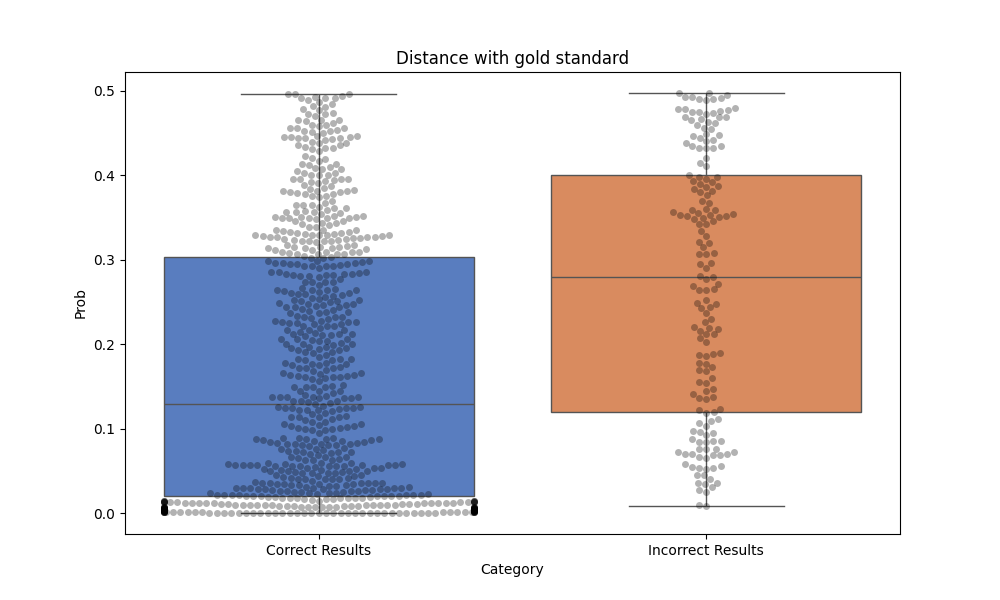

No such comm: aaa9149f16c448528d766f01ff647973


In [80]:
plt.close('all')
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Category', y='Prob', data=df, palette='muted')
sns.swarmplot(x='Category', y='Prob', data=df, color='k', alpha=0.3)
# Show the plot
plt.title('Distance with gold standard')
plt.show()


In [81]:
# Store results
all_results_amb = []
mean_pred_amb = []
true_labels_amb = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data_amb:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred_amb.append(np.mean(pred_probs))
        true_labels_amb.append(labels.item())
        all_results_amb.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [82]:
# Store results
all_results_amb_tr = []
mean_pred_amb_tr = []
true_labels_amb_tr = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in tr_data_amb:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred_amb_tr.append(np.mean(pred_probs))
        true_labels_amb_tr.append(labels.item())
        all_results_amb_tr.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [83]:
good_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class']]
bad_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class']]

In [84]:
good_results_round = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class'] and all_results[k]['true_label'] == 0]
good_results_irregular = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class'] and all_results[k]['true_label'] == 1]

bad_results_round = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class'] and all_results[k]['true_label'] == 0]
bad_results_irregular = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class'] and all_results[k]['true_label'] == 1]

In [85]:
good_prob_round = [good_results_round[k]['mean'] for k in range(len(good_results_round))]
bad_prob_round = [bad_results_round[k]['mean'] for k in range(len(bad_results_round))]
good_prob_irregular = [good_results_irregular[k]['mean'] for k in range(len(good_results_irregular))]
bad_prob_irregular = [bad_results_irregular[k]['mean'] for k in range(len(bad_results_irregular))]
amb_means = [all_results_amb[k]['mean'] for k in range(len(all_results_amb))]
amb_tr_means = [all_results_amb_tr[k]['mean'] for k in range(len(all_results_amb_tr))]

/tmp/ipykernel_912677/746132662.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Results', y='Prob', data=df, inner=None, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 35.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 35.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home

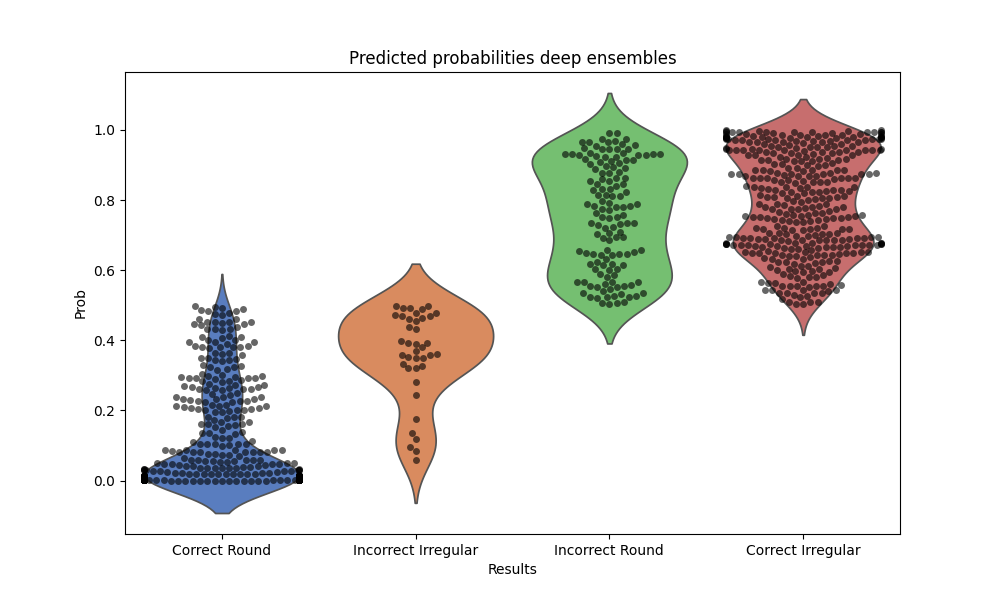

In [86]:
# Prepare the data in a long-form DataFrame
df = pd.DataFrame({
    'Prob': good_prob_round + bad_prob_irregular + bad_prob_round + good_prob_irregular, #+ amb_means + amb_tr_means,
    'Results': ['Correct Round'] * len(good_prob_round) + ['Incorrect Irregular'] * len(bad_prob_irregular) + ['Incorrect Round'] * len(bad_prob_round) + ['Correct Irregular'] * len(good_prob_irregular) #+ ['Ambiguous cuts: Eval DB'] * len(amb_means) + ['Train DB'] * len(amb_tr_means)
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x='Results', y='Prob', data=df, inner=None, palette='muted')

# Add the scatter points
sns.swarmplot(x='Results', y='Prob', data=df, color='k', alpha=0.6)

# Show the plot
plt.title('Predicted probabilities deep ensembles')
plt.show()

/tmp/ipykernel_912677/2735695580.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Results', y='Prob', data=df, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 34.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 34.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/ven

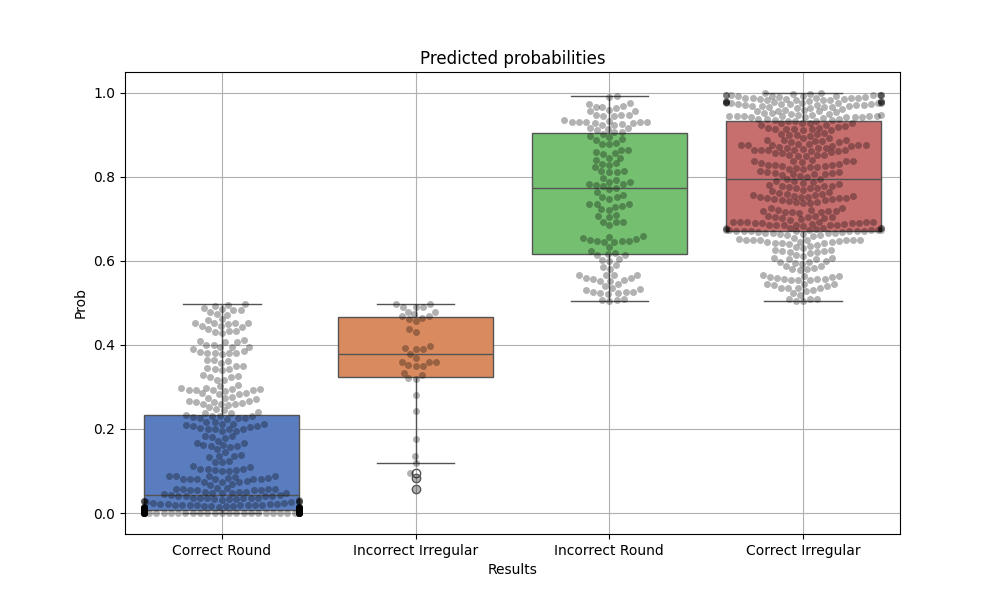

No such comm: 027ca3e3d4df4376871ddde32c68a291


In [87]:
plt.close('all')
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Results', y='Prob', data=df, palette='muted')
sns.swarmplot(x='Results', y='Prob', data=df, color='k', alpha=0.3)
# Show the plot
plt.title('Predicted probabilities')
plt.grid()
plt.show()

In [88]:
good_stds = [good_results[k]['std'] for k in range(len(good_results))]
bad_stds = [bad_results[k]['std'] for k in range(len(bad_results))]
amb_stds = [all_results_amb[k]['std'] for k in range(len(all_results_amb))]
amb_tr_stds = [all_results_amb_tr[k]['std'] for k in range(len(all_results_amb_tr))]

/tmp/ipykernel_912677/4009370409.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Std', data=df, inner=None, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


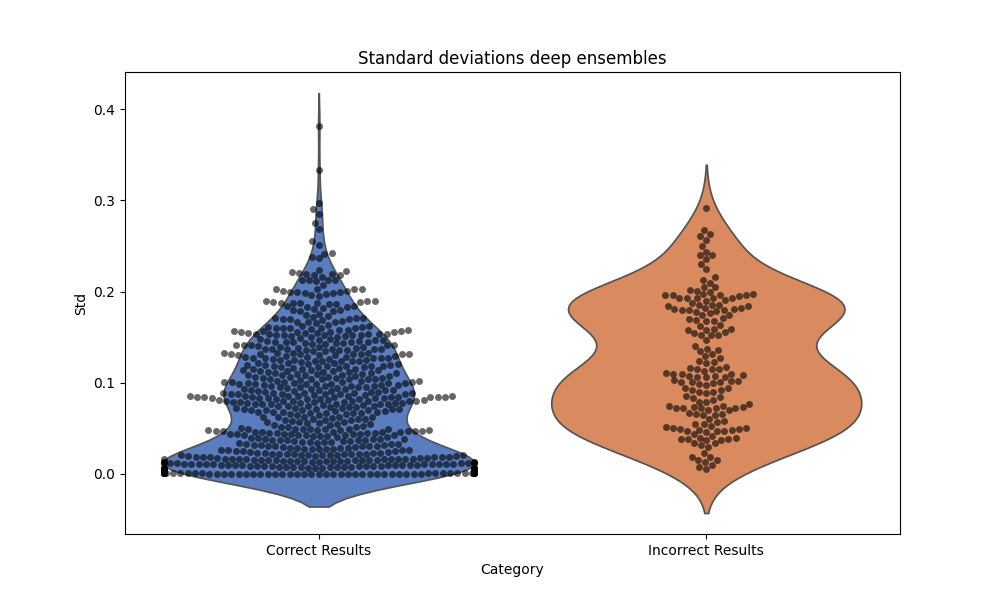

In [89]:
# Prepare the data in a long-form DataFrame
df = pd.DataFrame({
    'Std': good_stds + bad_stds,# + amb_stds + amb_tr_stds,
    'Category': ['Correct Results'] * len(good_stds) + ['Incorrect Results'] * len(bad_stds)# + ['Ambiguous Cuts Eval DB'] * len(amb_stds) + ['Train DB'] * len(amb_tr_stds)
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x='Category', y='Std', data=df, inner=None, palette='muted')

# Add the scatter points
sns.swarmplot(x='Category', y='Std', data=df, color='k', alpha=0.6)

# Show the plot
plt.title('Standard deviations deep ensembles')
plt.show()

/tmp/ipykernel_912677/1115309176.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Std', data=df, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 9.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


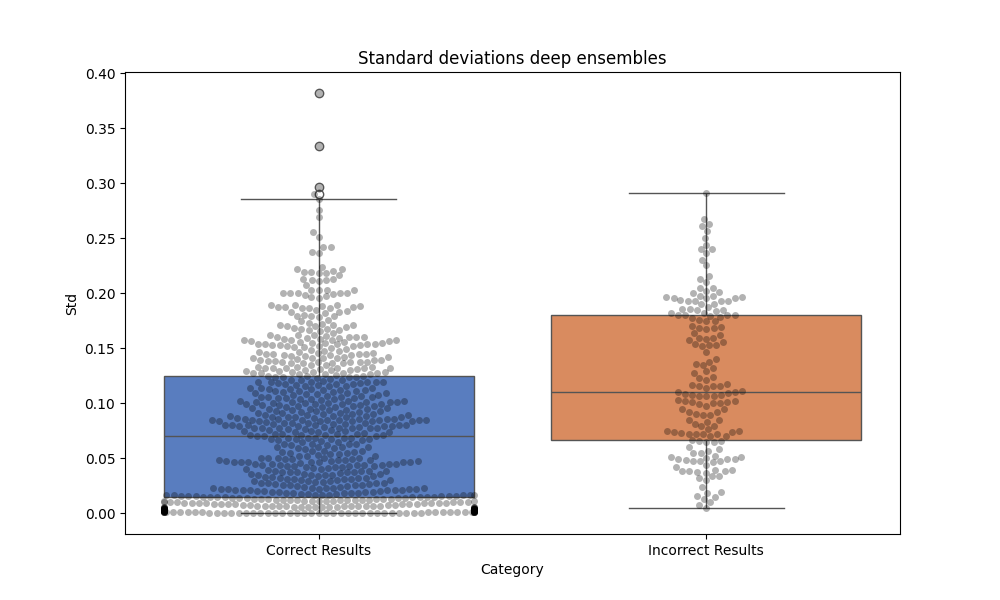

No such comm: bffd706e0374496bb46e1cedbe52ad92


In [90]:
plt.close('all')
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Category', y='Std', data=df, palette='muted')
sns.swarmplot(x='Category', y='Std', data=df, color='k', alpha=0.3)
# Show the plot
plt.title('Standard deviations deep ensembles')
plt.show()


In [91]:
# Load the models
model_paths = ['model_shape_0_augmented.pt', 'model_shape_1_augmented.pt', 'model_shape_2_augmented.pt', 'model_shape_3_augmented.pt', 'model_shape_4_augmented.pt']
models = []

for path in model_paths:
    model = simpleNet()
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    models.append(model)

In [92]:
# Store results
all_results = []
mean_pred = []
true_labels = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data:
        images = batch['image']
        labels = batch['shape']

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred.append(np.mean(pred_probs))
        true_labels.append(labels.item())
        all_results.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

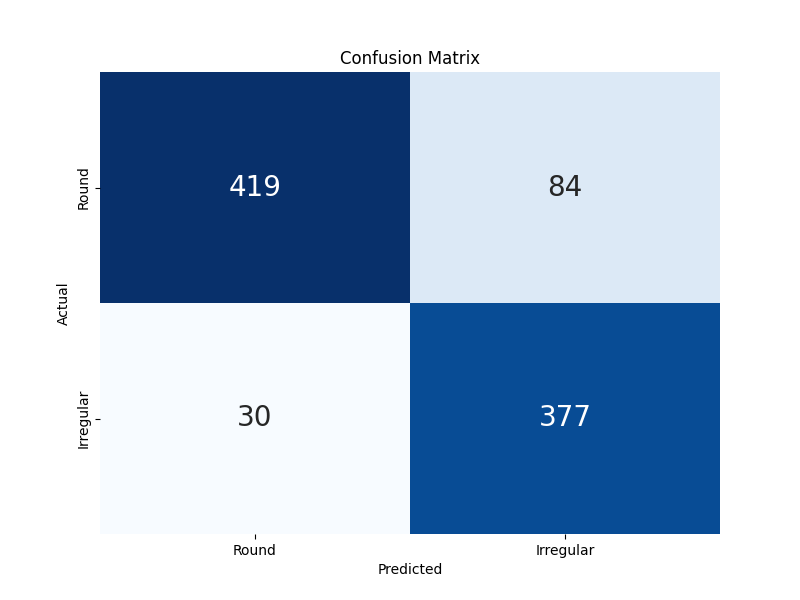

Accuracy: 0.874725 	F1 Score: 0.868664 	ROC AUC: 0.931902 	Specificity: 0.833002 	Sensitivity: 0.926290


In [93]:
models_pred = [[all_results[k]['predicted_probabilities'][i].ravel() for k in range(len(all_results))] for i in range(5)]
calculate_val_metrics(np.array(mean_pred), np.array(true_labels))

In [94]:
np.std((0.88, 0.86, 0.85, 0.9, 0.94))

0.03199999999999999

In [95]:
np.std((0.88, 0.87, 0.88, 0.87, 0.92))

0.018547236990991423

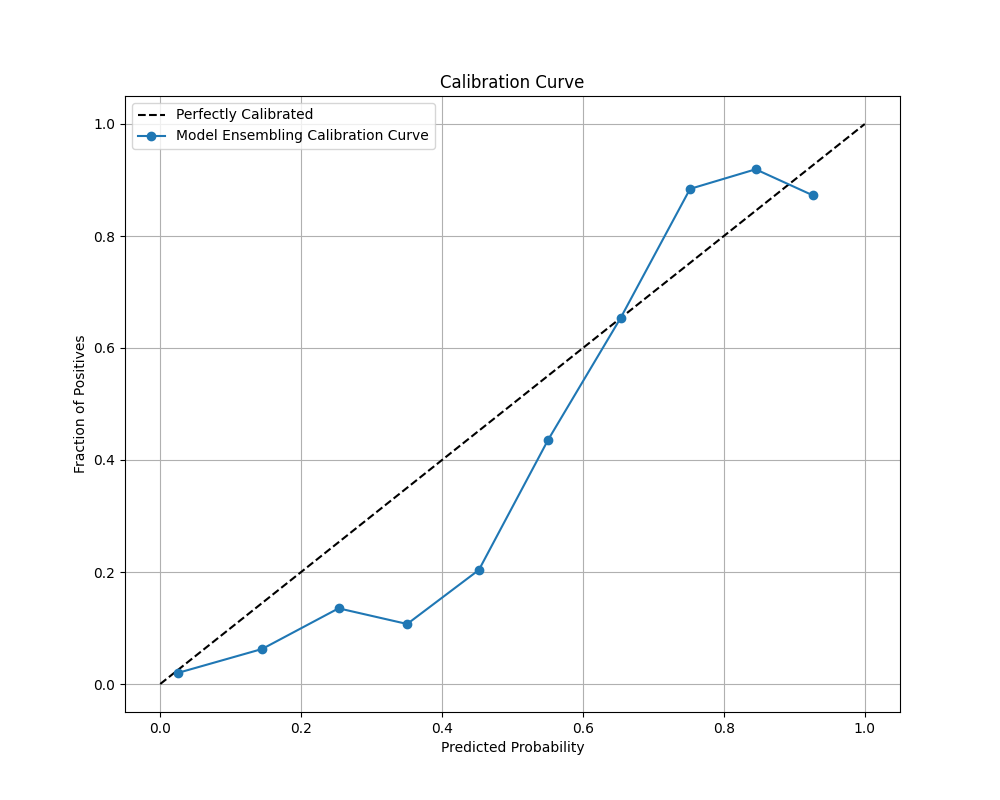

In [96]:
plt.figure(figsize=(10, 8))

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
i = 0
# for res in models_pred:
#     prob_true, prob_pred = plot_calibration_curve(np.array(true_labels), np.array(res).ravel())
#     plt.plot(prob_pred, prob_true, marker='o', label=f'Model_{i} Calibration Curve', alpha = 0.1)
#     i=i+1
prob_true, prob_pred = plot_calibration_curve(np.array(true_labels), np.array(mean_pred))
plt.plot(prob_pred, prob_true, marker='o', label=f'Model Ensembling Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()

In [44]:
good_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class']]
bad_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class']]
good_prob = [0.5-abs((good_results[k]['mean']-0.5)) for k in range(len(good_results))]
bad_prob = [0.5-abs((bad_results[k]['mean']-0.5)) for k in range(len(bad_results))]

failures = np.ones(len(bad_prob))
success = np.zeros(len(good_prob))

In [45]:
good_stds = [good_results[k]['std'] for k in range(len(good_results))]
bad_stds = [bad_results[k]['std'] for k in range(len(bad_results))]

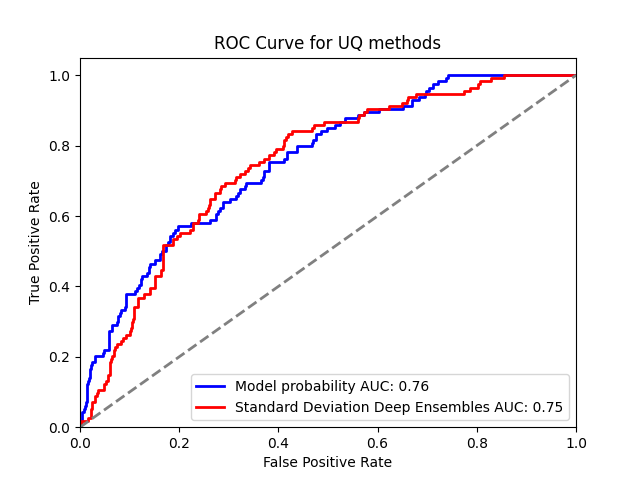

AUC: 0.76
AUC: 0.75


In [46]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(np.concatenate((failures, success)), np.concatenate((bad_prob, good_prob)))
fpr_stds, tpr_stds, thresholds_stds = roc_curve(np.concatenate((failures, success)), np.concatenate((bad_stds, good_stds)))

# Calculate and print AUC
auc_score = roc_auc_score(np.concatenate((failures, success)), np.concatenate((bad_prob, good_prob)))
auc_score_stds = roc_auc_score(np.concatenate((failures, success)), np.concatenate((bad_stds, good_stds)))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Model probability AUC: {auc_score:.2f}')
plt.plot(fpr_stds, tpr_stds, color='red', lw=2, label=f'Standard Deviation Deep Ensembles AUC: {auc_score_stds:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for UQ methods')
plt.legend(loc="lower right")
plt.show()


print(f'AUC: {auc_score:.2f}')
print(f'AUC: {auc_score_stds:.2f}')

In [ ]:
# Prepare the data in a long-form DataFrame
df = pd.DataFrame({
    'Prob': good_prob + bad_prob,# + amb_stds + amb_tr_stds,
    'Category': ['Correct Results'] * len(good_prob) + ['Incorrect Results'] * len(bad_prob)# + ['Ambiguous Cuts Eval DB'] * len(amb_stds) + ['Train DB'] * len(amb_tr_stds)
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x='Category', y='Prob', data=df, inner=None, palette='muted')

# Add the scatter points
sns.swarmplot(x='Category', y='Prob', data=df, color='k', alpha=0.6)

# Show the plot
plt.title('Distance with gold standard')
plt.show()

In [ ]:
plt.close('all')
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Category', y='Prob', data=df, palette='muted')
sns.swarmplot(x='Category', y='Prob', data=df, color='k', alpha=0.3)
# Show the plot
plt.title('Distance with gold standard')
plt.show()

In [40]:
# Store results
all_results_amb = []
mean_pred_amb = []
true_labels_amb = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data_amb:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred_amb.append(np.mean(pred_probs))
        true_labels_amb.append(labels.item())
        all_results_amb.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [41]:
# Store results
all_results_amb_tr = []
mean_pred_amb_tr = []
true_labels_amb_tr = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in tr_data_amb:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred_amb_tr.append(np.mean(pred_probs))
        true_labels_amb_tr.append(labels.item())
        all_results_amb_tr.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs),
            'mean': np.mean(pred_probs)
        })

In [42]:
good_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class']]
bad_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class']]

good_results_round = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class'] and all_results[k]['true_label'] == 0]
good_results_irregular = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class'] and all_results[k]['true_label'] == 1]

bad_results_round = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class'] and all_results[k]['true_label'] == 0]
bad_results_irregular = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class'] and all_results[k]['true_label'] == 1]

good_prob_round = [good_results_round[k]['mean'] for k in range(len(good_results_round))]
bad_prob_round = [bad_results_round[k]['mean'] for k in range(len(bad_results_round))]
good_prob_irregular = [good_results_irregular[k]['mean'] for k in range(len(good_results_irregular))]
bad_prob_irregular = [bad_results_irregular[k]['mean'] for k in range(len(bad_results_irregular))]
amb_means = [all_results_amb[k]['mean'] for k in range(len(all_results_amb))]
amb_tr_means = [all_results_amb_tr[k]['mean'] for k in range(len(all_results_amb_tr))]

In [ ]:
# Prepare the data in a long-form DataFrame
df = pd.DataFrame({
    'Prob': good_prob_round + bad_prob_irregular + bad_prob_round + good_prob_irregular,# + amb_means + amb_tr_means,
    'Results': ['Correct Round'] * len(good_prob_round) + ['Incorrect Irregular'] * len(bad_prob_irregular) + ['Incorrect Round'] * len(bad_prob_round) + ['Correct Irregular'] * len(good_prob_irregular) #+ ['Ambiguous cuts: Eval DB'] * len(amb_means) + ['Train DB'] * len(amb_tr_means)
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x='Results', y='Prob', data=df, inner=None, palette='muted')

# Add the scatter points
sns.swarmplot(x='Results', y='Prob', data=df, color='k', alpha=0.6)

# Show the plot
plt.title('Predicted probabilities deep ensembles')
plt.show()

In [ ]:
plt.close('all')
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Results', y='Prob', data=df, palette='muted')
sns.swarmplot(x='Results', y='Prob', data=df, color='k', alpha=0.3)
# Show the plot
plt.title('Predicted probabilities')
plt.grid()
plt.show()

In [46]:
good_stds = [good_results[k]['std'] for k in range(len(good_results))]
bad_stds = [bad_results[k]['std'] for k in range(len(bad_results))]
amb_stds = [all_results_amb[k]['std'] for k in range(len(all_results_amb))]
amb_tr_stds = [all_results_amb_tr[k]['std'] for k in range(len(all_results_amb_tr))]

In [ ]:
# Prepare the data in a long-form DataFrame
df = pd.DataFrame({
    'Std': good_stds + bad_stds,# + amb_stds + amb_tr_stds,
    'Category': ['Correct Results'] * len(good_stds) + ['Incorrect Results'] * len(bad_stds)# + ['Ambiguous Cuts Eval DB'] * len(amb_stds) + ['Train DB'] * len(amb_tr_stds)
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x='Category', y='Std', data=df, inner=None, palette='muted')

# Add the scatter points
sns.swarmplot(x='Category', y='Std', data=df, color='k', alpha=0.6)

# Show the plot
plt.title('Standard deviations deep ensembles')
plt.show()

In [ ]:
plt.close('all')
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Category', y='Std', data=df, palette='muted')
sns.swarmplot(x='Category', y='Std', data=df, color='k', alpha=0.3)
#plt.ylim(-0.02, 0.4)
# Show the plot
plt.title('Standard deviations deep ensembles')
plt.show()
